# Laboratorio Graph Embeddings

En este laboratorio crearemos un grafo sintético y entrenaremos una GNN para predecir etiquetas.

Estas primeras celdas le permitirán verificar las versiones del software disponible en Colab e instalar las librerías faltantes.

In [1]:
!python -c "import torch; print(torch.version.cuda)"

12.4


In [2]:
!python -c "import torch; print(torch.__version__)"

2.6.0+cu124


In [3]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.6.0+cu124.html

Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html


In [4]:
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.6.0+cu124.html

Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html


In [5]:
!pip install torch-geometric

In [6]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx
import random
import numpy as np
from sklearn.cluster import KMeans

In [7]:
# 1. Crear distintos tipos de grafo y asignar etiquetas
def spectral_labels(G, k=3):
    lap = nx.normalized_laplacian_matrix(G).todense()
    eigvecs = np.linalg.eigh(lap)[1][:, 1:k+1]
    return KMeans(n_clusters=k, random_state=42).fit_predict(eigvecs)

def generate_graph(graph_type='sbm', num_nodes=150):
    if graph_type == 'sbm':
        sizes = [num_nodes // 3] * 3
        probs = [[0.3, 0.05, 0.02], [0.05, 0.3, 0.04], [0.02, 0.04, 0.3]]
        G = nx.stochastic_block_model(sizes, probs, seed=42)
        labels = [i for i, size in enumerate(sizes) for _ in range(size)]
    elif graph_type == 'erdos':
        G = nx.erdos_renyi_graph(num_nodes, 0.05, seed=42)
        labels = spectral_labels(G)
    elif graph_type == 'barabasi':
        G = nx.barabasi_albert_graph(num_nodes, 2, seed=42)
        labels = spectral_labels(G)
    else:
        raise ValueError("Unknown graph type")

    G = max((G.subgraph(c) for c in nx.connected_components(G)), key=len)
    edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()
    features = torch.eye(G.number_of_nodes())
    labels = torch.tensor(labels[:G.number_of_nodes()], dtype=torch.long)
    return G, features, labels, edge_index

In [8]:
# 2. GCN
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=2):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        # Primera capa
        self.convs.append(GCNConv(in_channels, hidden_channels))
        # Capas subsiguientes
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
        # Capa output
        self.convs.append(GCNConv(hidden_channels, out_channels))

    def forward(self, x, edge_index):
        # Aplicamos RELU a las capas
        for conv in self.convs[:-1]:
            x = F.relu(conv(x, edge_index))
        # Ultima capa sin RELU
        return self.convs[-1](x, edge_index)

In [9]:
# 3. entrenamiento y test
def train(model, data, loss_fn):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    model.train()
    for epoch in range(101):
        out = model(data.x, data.edge_index)
        loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        if epoch % 20 == 0:
            print(f"Epoch {epoch} | Loss: {loss.item():.4f}")

def test(model, data):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    acc = int((pred[data.test_mask] == data.y[data.test_mask]).sum()) / int(data.test_mask.sum())
    print(f"Test Accuracy: {acc:.4f}")


In [10]:
# 4. Ejemplo de ejecución
# Elegir tipo de grafo: 'sbm', 'erdos', 'barabasi'
G, X, Y, E = generate_graph('barabasi')
n = X.size(0)
train_mask = torch.zeros(n, dtype=torch.bool); train_mask[:int(0.8*n)] = True
test_mask = ~train_mask
data = Data(x=X, edge_index=E, y=Y, train_mask=train_mask, test_mask=test_mask)

model = GCN(X.size(1), 16, 3, 2)
train(model, data, F.cross_entropy)
test(model, data)

Epoch 0 | Loss: 1.0810
Epoch 20 | Loss: 0.6974
Epoch 40 | Loss: 0.3739
Epoch 60 | Loss: 0.1913
Epoch 80 | Loss: 0.1131
Epoch 100 | Loss: 0.0749
Test Accuracy: 0.8667


# Extra?

## Visualización del grafo
Vizualisemos el grafo elejido (barbasi en este caso):

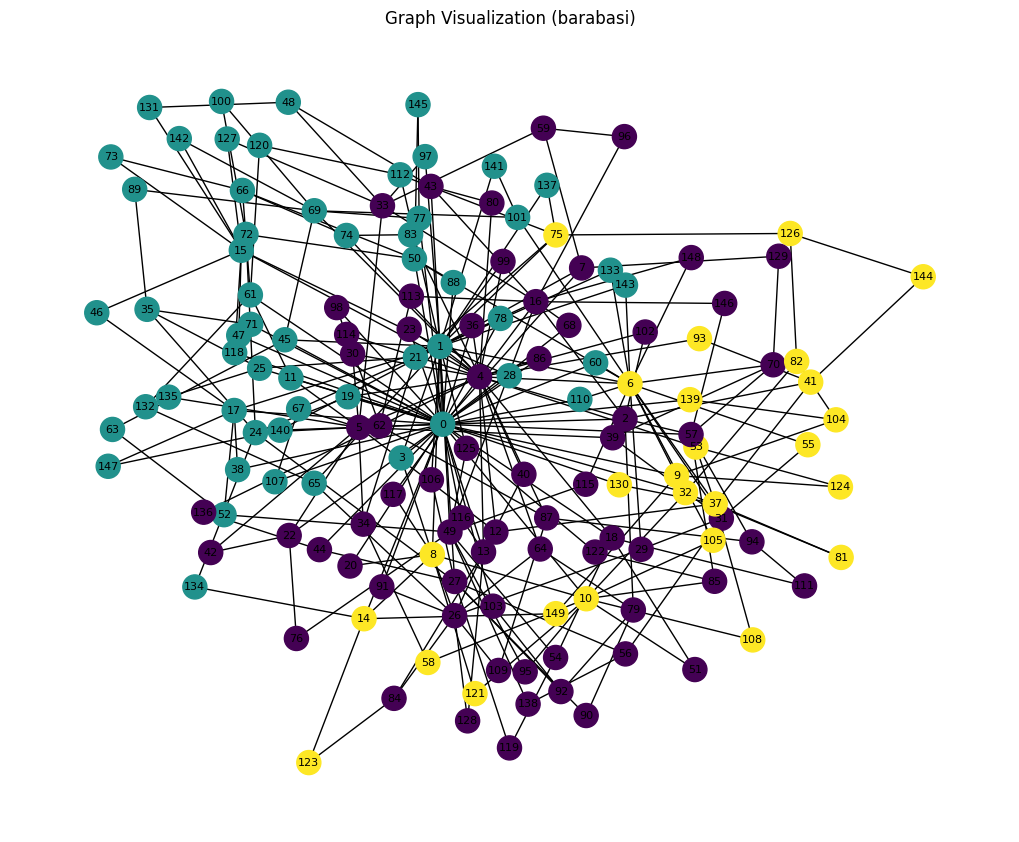

In [15]:
import matplotlib.pyplot as plt

# Visualize the graph
plt.figure(figsize=(10, 8))
nx.draw(G, with_labels=True, node_color=Y.numpy(), node_size=300, font_size=8)
plt.title(f'Graph Visualization ({graph_type})')
plt.show()

## Almacenamiento y vizualizacion de embeddings
Modifique el código Python proporcionado para almacenar embeddings de nodos en épocas específicas durante el entrenamiento, luego se visualzan estas estos embeddings usando t-SNE en diferentes etapas de entrenamiento para observar la separación de clases.

In [16]:
# 3. entrenamiento y test
def train(model, data, loss_fn, save_epochs=[]):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    model.train()
    embeddings = {}
    for epoch in range(201):
        out = model(data.x, data.edge_index)
        loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
        optimizer.zero_grad(); loss.backward(); optimizer.step()

        if epoch in save_epochs:
            # Obtener embeddings antes de la capa final
            with torch.no_grad():
                intermediate_output = data.x
                for i, conv in enumerate(model.convs[:-1]):
                    intermediate_output = F.relu(conv(intermediate_output, data.edge_index))
                embeddings[epoch] = intermediate_output.detach().numpy()

        # Vemos las metricas cada 20 epocas
        if epoch % 20 == 0:
            print(f"Epoch {epoch} | Loss: {loss.item():.4f}")
    return embeddings

def test(model, data):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    acc = int((pred[data.test_mask] == data.y[data.test_mask]).sum()) / int(data.test_mask.sum())
    print(f"Test Accuracy: {acc:.4f}")

## Obtener los embeddings

Ahora ejecutamos la función de entrenamiento modificada para los diferentes tipos de grafos y guardamos los embeddings para ciertas epochs.

In [17]:
# 4. Ejemplo de ejecución
graph_types = ['sbm', 'erdos', 'barabasi']
save_epochs = [0, 50, 100, 150, 200]
all_embeddings = {}

for graph_type in graph_types:
    print(f"Processing graph type: {graph_type}")

    G, X, Y, E = generate_graph(graph_type)
    n = X.size(0)
    num_classes = Y.max().item() + 1

    # Mascaras
    train_mask = torch.zeros(n, dtype=torch.bool)
    test_mask = torch.zeros(n, dtype=torch.bool)

    # Asegurar de que las máscaras de train y de test no se superpongan y cubran todos los nodos
    indices = torch.randperm(n)
    train_size = int(0.8 * n)
    train_indices = indices[:train_size]
    test_indices = indices[train_size:]

    train_mask[train_indices] = True
    test_mask[test_indices] = True

    data = Data(x=X, edge_index=E, y=Y, train_mask=train_mask, test_mask=test_mask)

    model = GCN(X.size(1), 16, num_classes, 2)
    print("Starting training...")
    embeddings = train(model, data, F.cross_entropy, save_epochs=save_epochs)
    all_embeddings[graph_type] = embeddings # Almacenamos los embeddings para el grafo.
    print("Starting testing...")
    test(model, data)
    print("-" * 30)

Processing graph type: sbm
Starting training...
Epoch 0 | Loss: 1.1079
Epoch 20 | Loss: 0.5426
Epoch 40 | Loss: 0.1709
Epoch 60 | Loss: 0.0685
Epoch 80 | Loss: 0.0371
Epoch 100 | Loss: 0.0235
Epoch 120 | Loss: 0.0164
Epoch 140 | Loss: 0.0121
Epoch 160 | Loss: 0.0093
Epoch 180 | Loss: 0.0074
Epoch 200 | Loss: 0.0061
Starting testing...
Test Accuracy: 1.0000
------------------------------
Processing graph type: erdos
Starting training...
Epoch 0 | Loss: 1.0995
Epoch 20 | Loss: 0.5792
Epoch 40 | Loss: 0.2207
Epoch 60 | Loss: 0.1046
Epoch 80 | Loss: 0.0583
Epoch 100 | Loss: 0.0358
Epoch 120 | Loss: 0.0239
Epoch 140 | Loss: 0.0170
Epoch 160 | Loss: 0.0127
Epoch 180 | Loss: 0.0099
Epoch 200 | Loss: 0.0079
Starting testing...
Test Accuracy: 0.8000
------------------------------
Processing graph type: barabasi
Starting training...
Epoch 0 | Loss: 1.1053
Epoch 20 | Loss: 0.7109
Epoch 40 | Loss: 0.2904
Epoch 60 | Loss: 0.1273
Epoch 80 | Loss: 0.0726
Epoch 100 | Loss: 0.0475
Epoch 120 | Loss: 0.0

## Visualizar los embeddings

Para cada conjunto de embeddings, usamos t-SNE para reducir la dimensionalidad y visualizarlos en 2D, coloreadas por sus etiquetas de clase.


Visualizing embeddings for graph type: sbm
  Applying t-SNE for epoch: 0


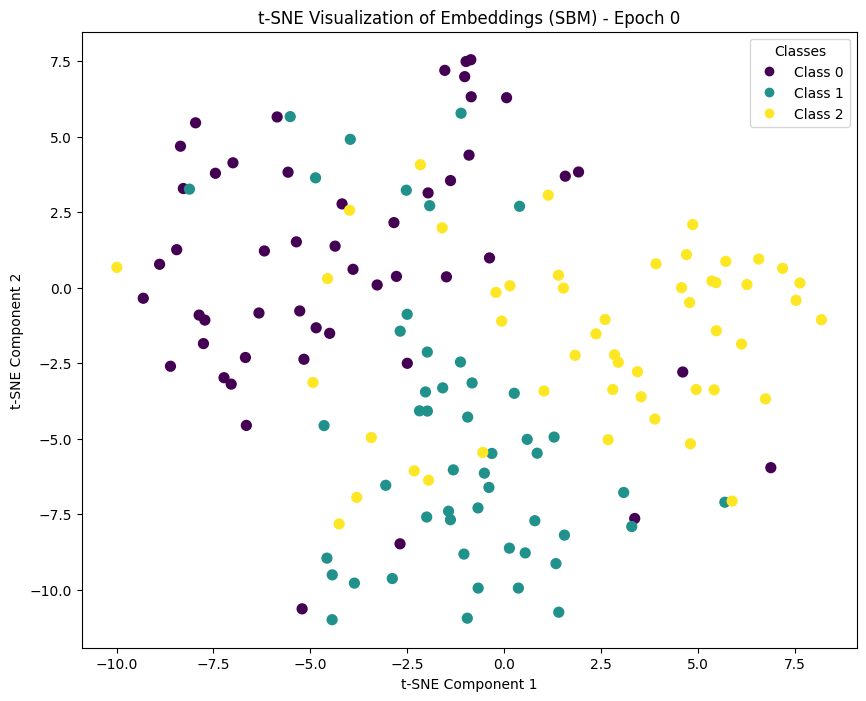

  Applying t-SNE for epoch: 50


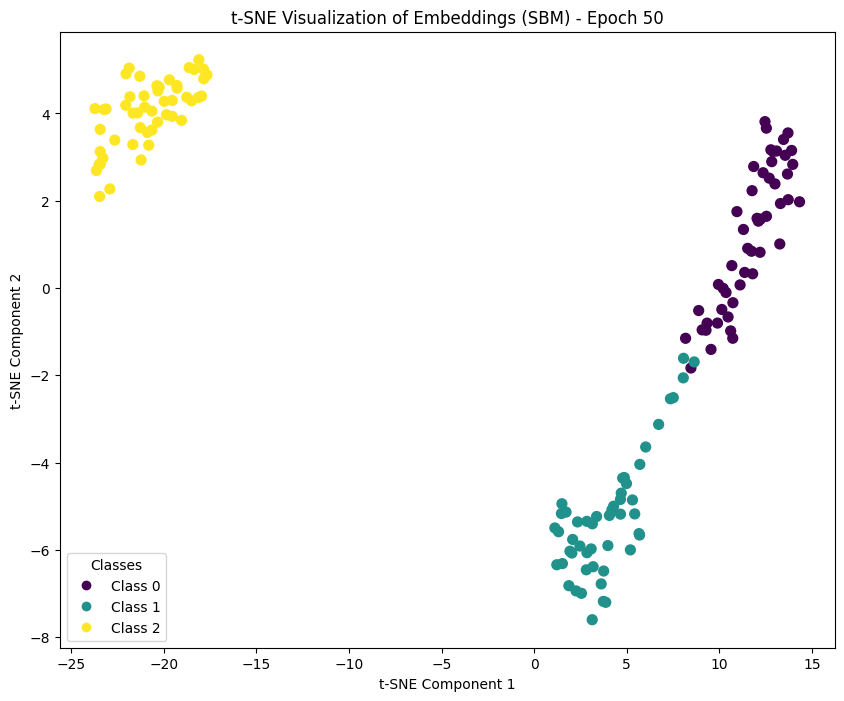

  Applying t-SNE for epoch: 100


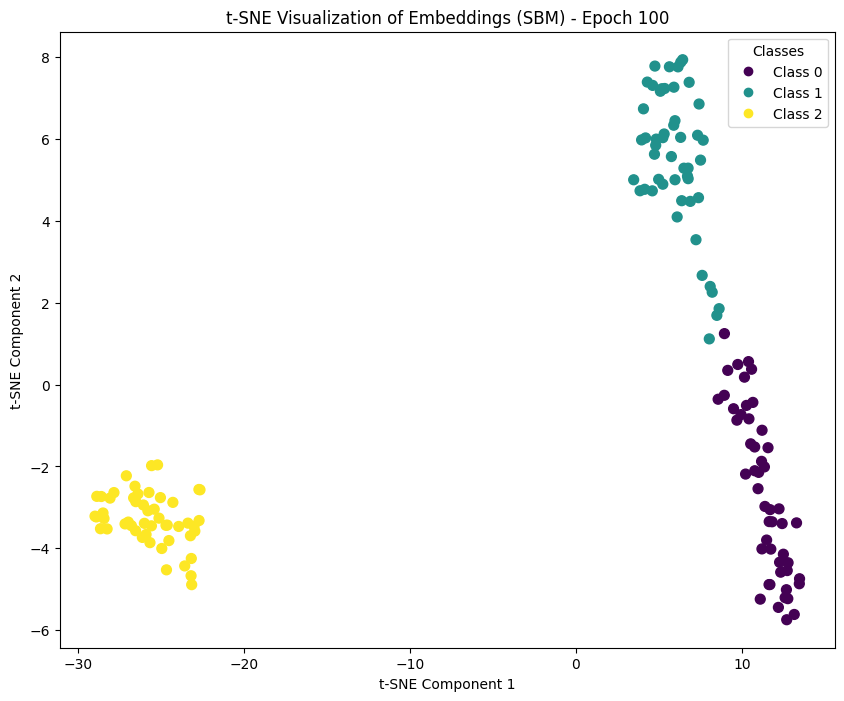

  Applying t-SNE for epoch: 150


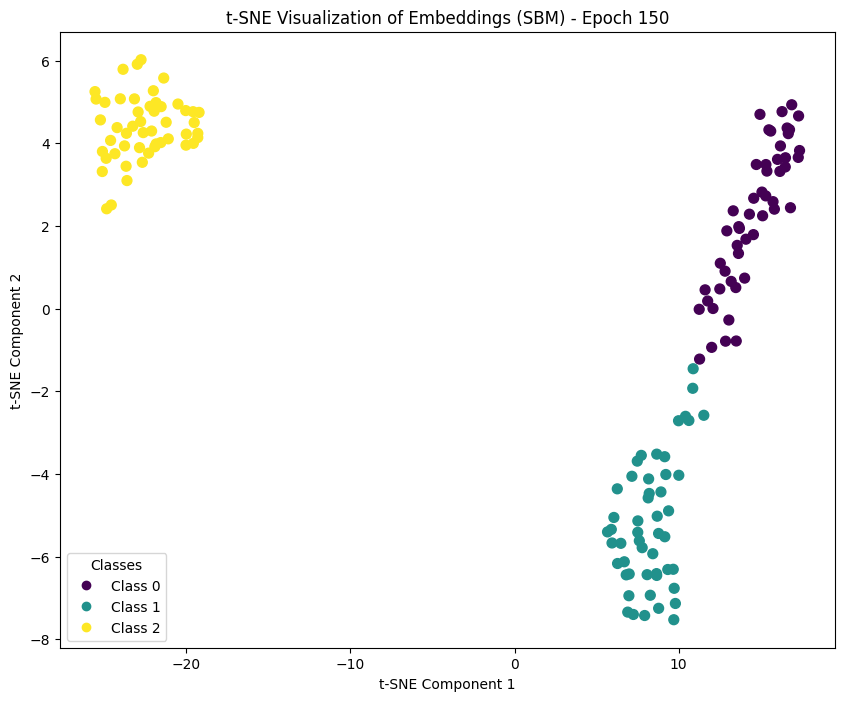

  Applying t-SNE for epoch: 200


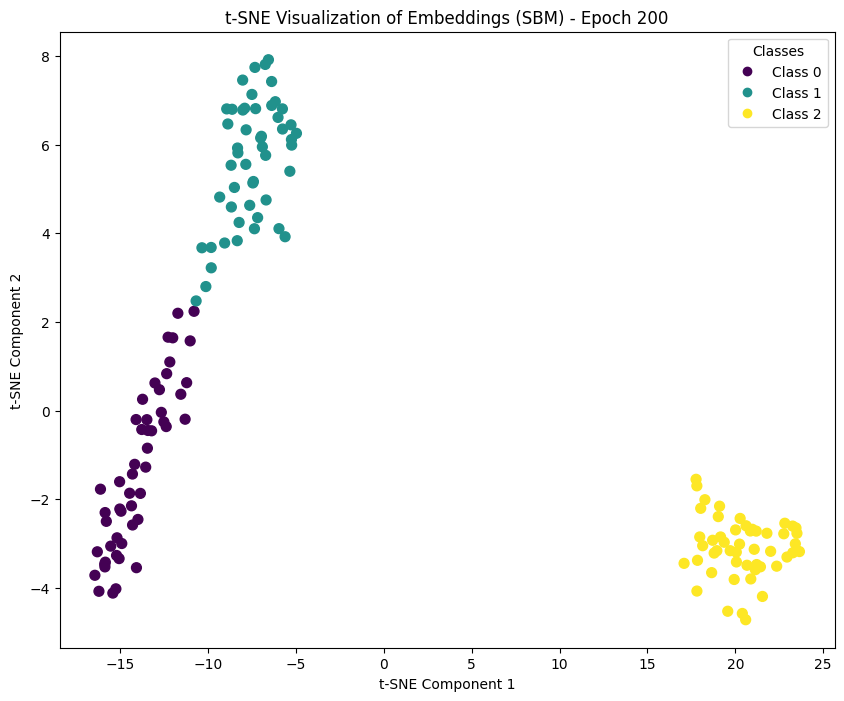

Visualizing embeddings for graph type: erdos
  Applying t-SNE for epoch: 0


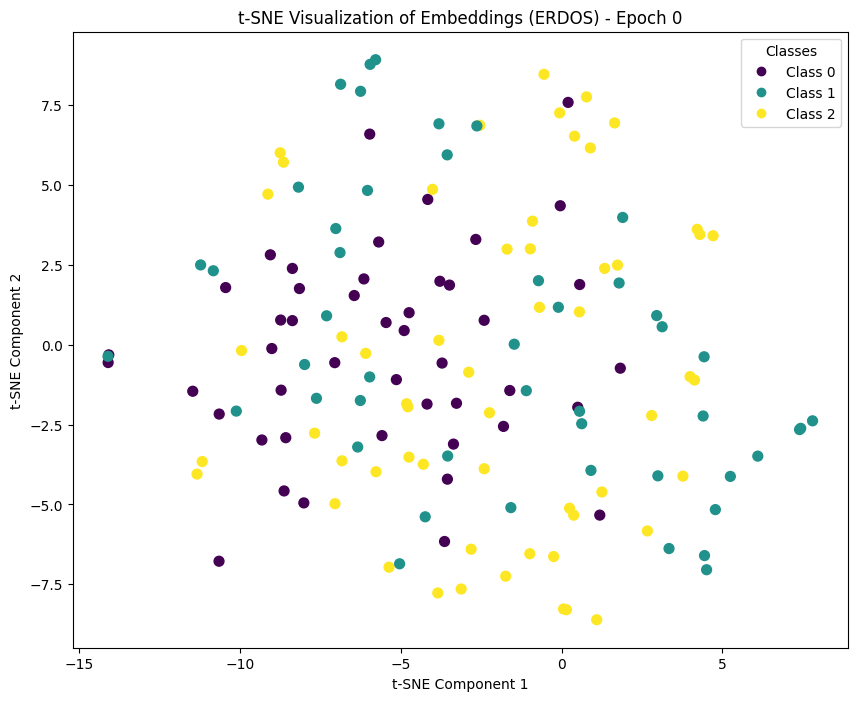

  Applying t-SNE for epoch: 50


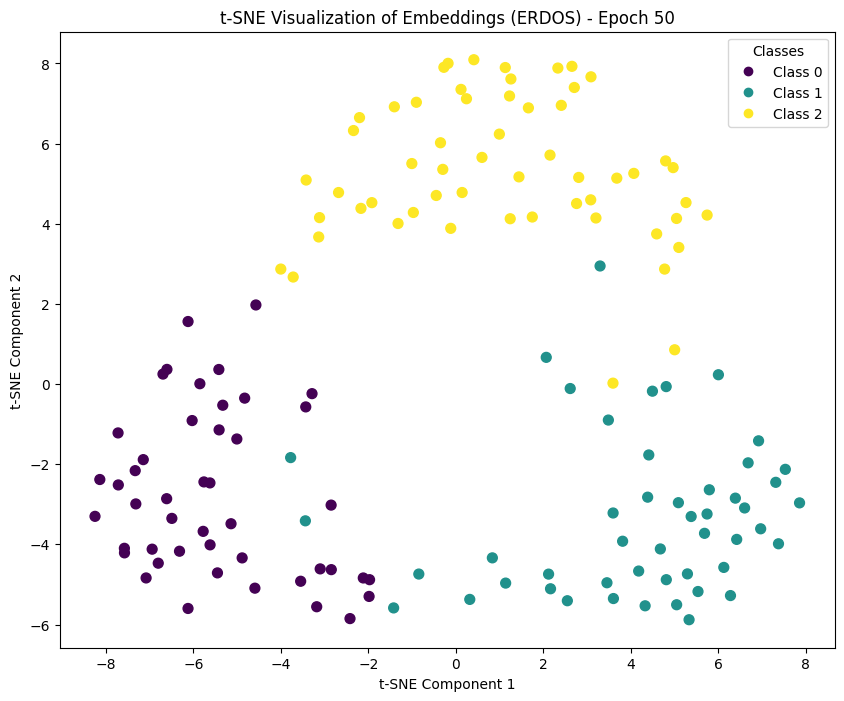

  Applying t-SNE for epoch: 100


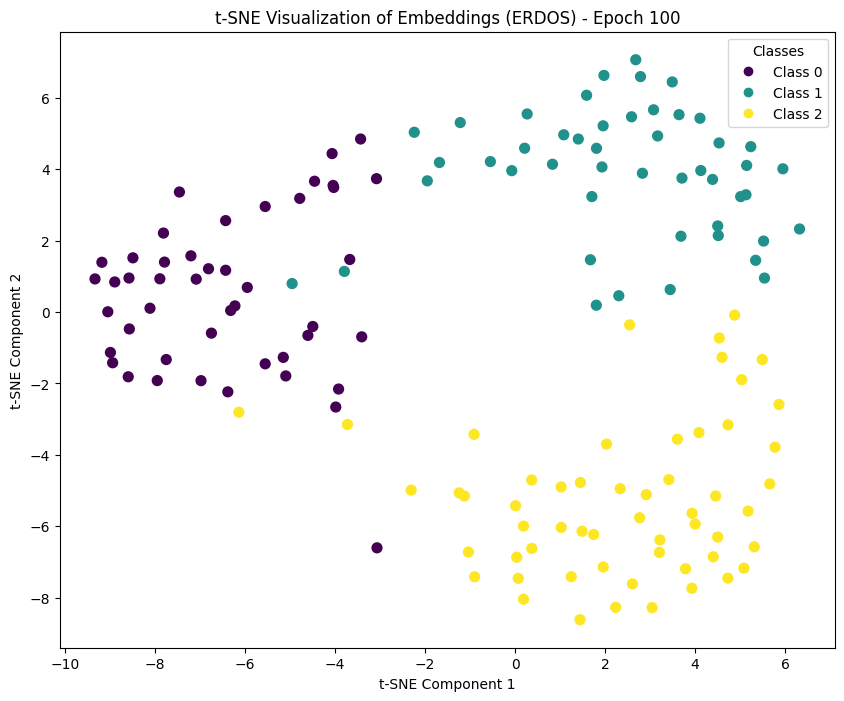

  Applying t-SNE for epoch: 150


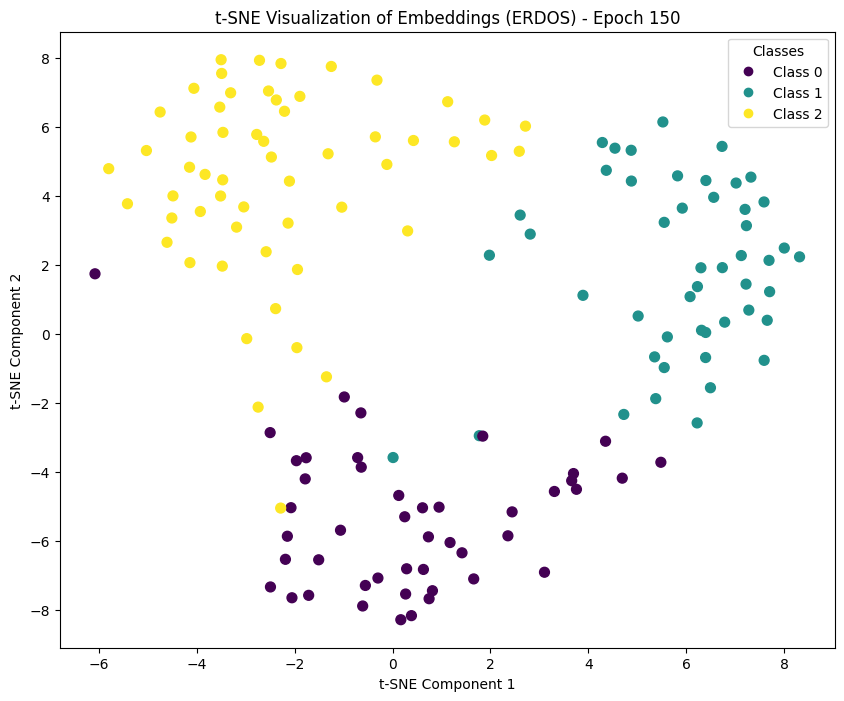

  Applying t-SNE for epoch: 200


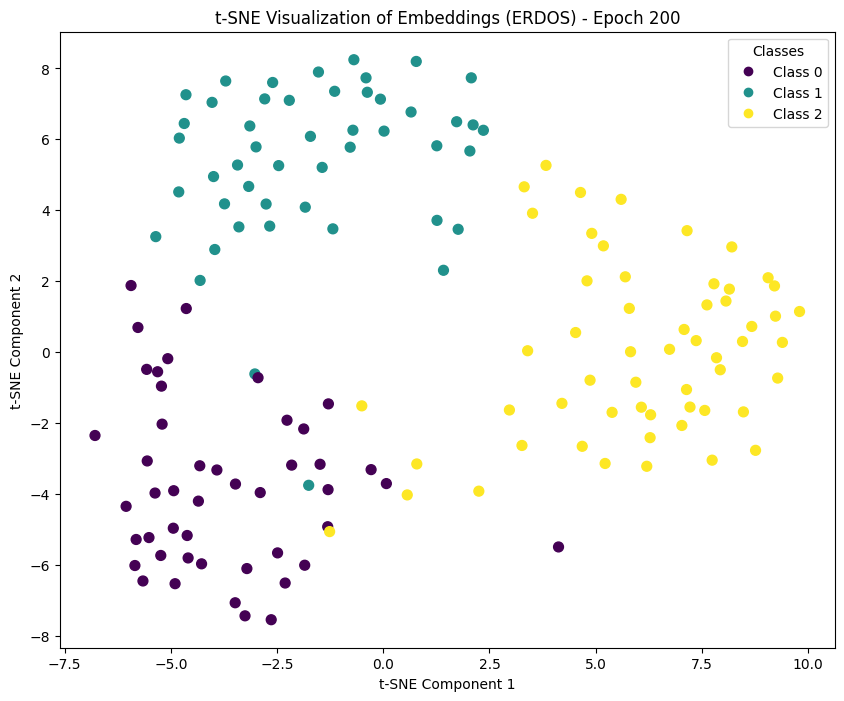

Visualizing embeddings for graph type: barabasi
  Applying t-SNE for epoch: 0


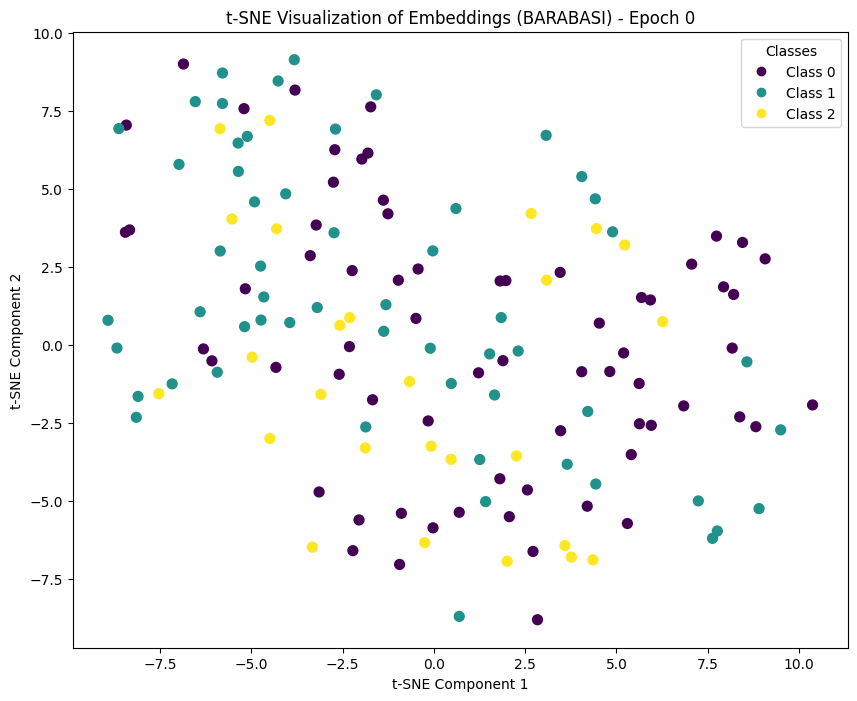

  Applying t-SNE for epoch: 50


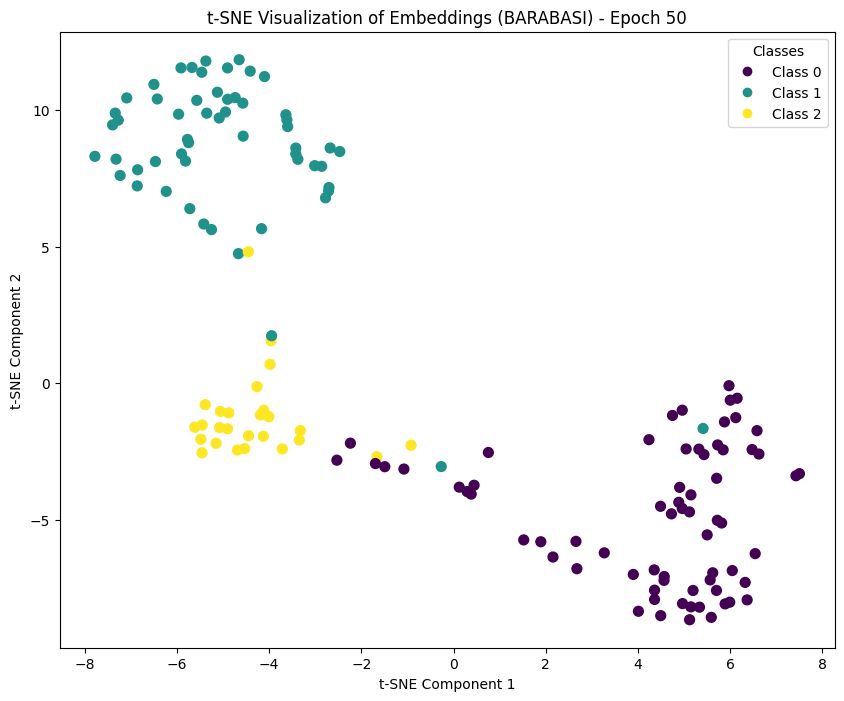

  Applying t-SNE for epoch: 100


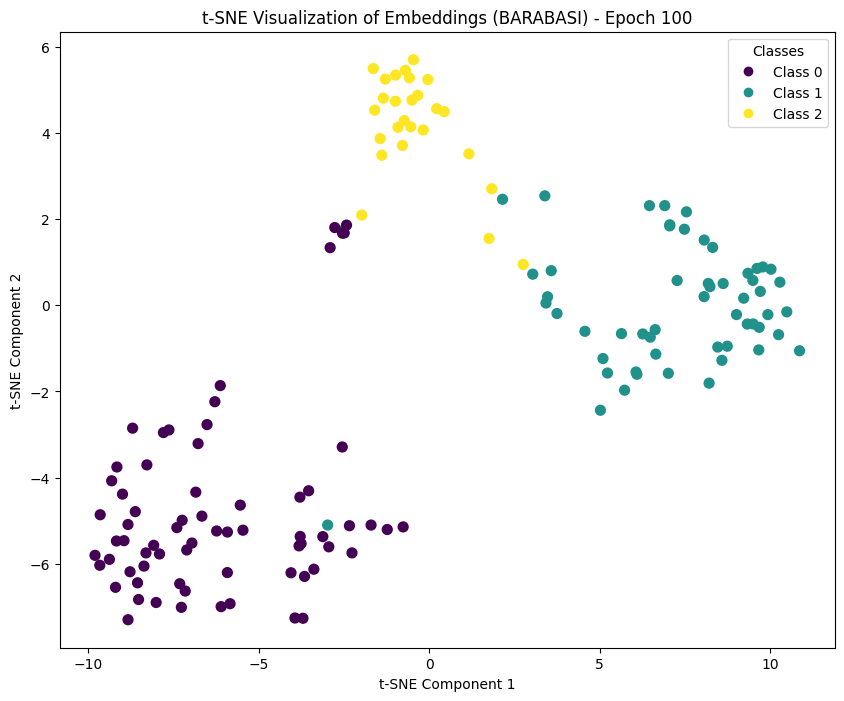

  Applying t-SNE for epoch: 150


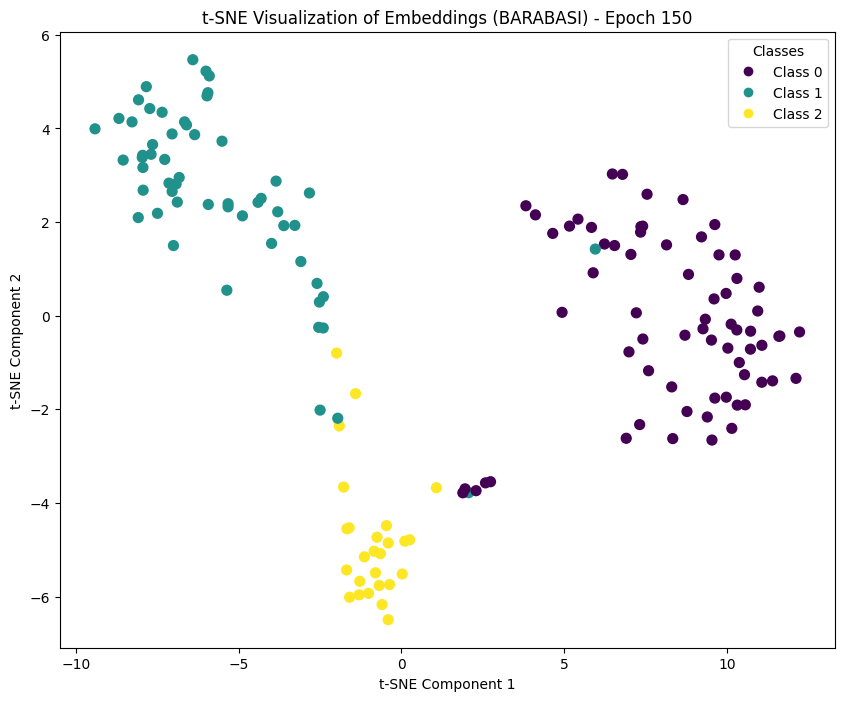

  Applying t-SNE for epoch: 200


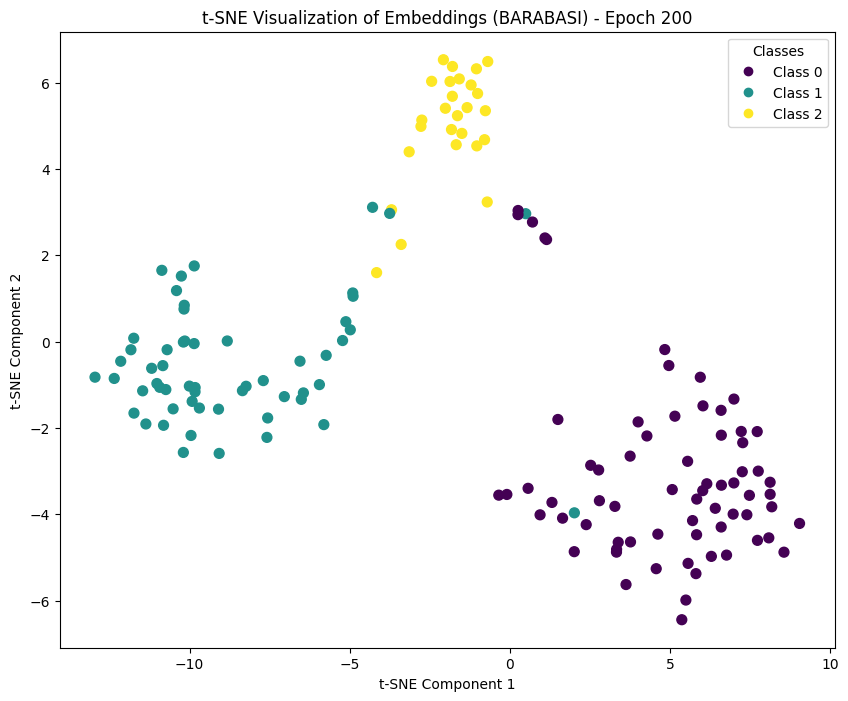

In [18]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# Iterar a través de tipos de gráficos
for graph_type, embeddings_by_epoch in all_embeddings.items():
    print(f"Visualizing embeddings for graph type: {graph_type}")

    # Otra vez se generan los grafos para obtener las etiquetas Y correctas
    _, _, Y, _ = generate_graph(graph_type)
    num_classes = Y.max().item() + 1

    # Iterar a traves de los embeddings en diferentes epochs
    for epoch, embeddings in embeddings_by_epoch.items():
        print(f"  Applying t-SNE for epoch: {epoch}")

        # Se aplica t-SNE
        tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
        embeddings_reduced = tsne.fit_transform(embeddings)

        # Visualizacion en 2D
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(embeddings_reduced[:, 0], embeddings_reduced[:, 1], c=Y.numpy(), cmap='viridis', s=50)
        plt.title(f't-SNE Visualization of Embeddings ({graph_type.upper()}) - Epoch {epoch}')
        plt.xlabel('t-SNE Component 1')
        plt.ylabel('t-SNE Component 2')

        # leyenda
        legend_labels = [f'Class {i}' for i in range(num_classes)]
        plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title="Classes")

        plt.show()

## Sintesis

### Hallazgos.

*   La loss de entrenamiento disminuyó con las épocas para todos los tipos de grafos, lo que indica un entrenamiento exitoso del modelo.
*   Las accuracy en el test después del entrenamiento fueron de 1.0000 para SBM, 0.8000 para Erdos y 0.7333 para los grafos Barabasi.
*   Ya desde la primera vizualizacion despues de el epoch 0 (epoch 50), las clases aparecían más claramente agrupadas y separadas en los gráficos t-SNE en comparación.


### Insights.

*   La visualización confirma que el modelo GCN aprende representaciones de nodos significativas que mejoran la separabilidad de clases durante el entrenamiento.
*   Las metricas y vizualisaciuones sugieren que la capacidad del modelo para separar clases podría estar influenciada por la estructura subyacente del grafo, siendo SBM la que muestra la separación más clara.
